In [18]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
from transformers import AutoModel, AutoTokenizer, logging
from datasets import load_dataset
from copy import deepcopy

from outliersvsfreq.pyplot.plotting_correlation import stack_plot_corr, stack_plot_freq
from outliersvsfreq.parameter_hiding import zero_param_

model_name = "roberta-base"

if model_name == "roberta-base":
    outliers_idxs = [77, 588]
elif model_name == "bert-base-uncased":
    outliers_idxs = [308, 381]

In [19]:
freqs = torch.load(f"output/outlier_correlations/{model_name}/freqs.bin")
hidden_states_special = torch.load(f"output/outlier_correlations/{model_name}/hidden_states_special.bin")
attention_special = torch.load(f"output/outlier_correlations/{model_name}/attentions_special.bin")
masks_special = torch.load(f"output/outlier_correlations/{model_name}/masks_special.bin")

hidden_states_no_special = torch.load(f"output/outlier_correlations/{model_name}/hidden_states_no_special.bin")
attention_no_special = torch.load(f"output/outlier_correlations/{model_name}/attentions_no_special.bin")
masks_no_special = torch.load(f"output/outlier_correlations/{model_name}/masks_no_special.bin")

(<Figure size 360x360 with 1 Axes>, <AxesSubplot:>)

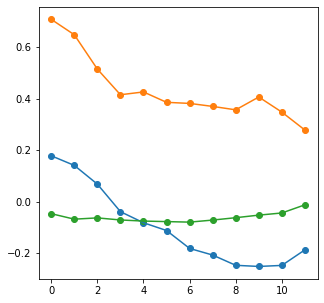

In [20]:
stack_plot_freq(
    freqs, {j:[torch.abs(i) for i in k] for j,k in hidden_states_special.items()}, masks_special,
    outliers_idxs=outliers_idxs, random_dims=set(hidden_states_special.keys()).difference([308, 381])
)

(<Figure size 360x360 with 1 Axes>, <AxesSubplot:>)

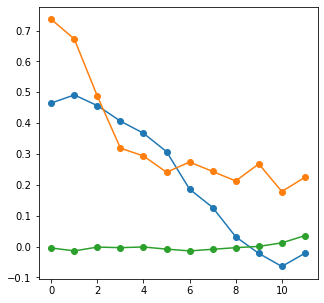

In [21]:
stack_plot_freq(
    freqs, {j:[torch.abs(i) for i in k] for j,k in hidden_states_no_special.items()}, masks_no_special,
    outliers_idxs=outliers_idxs, random_dims=set(hidden_states_special.keys()).difference([308, 381])
)

(<Figure size 720x360 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

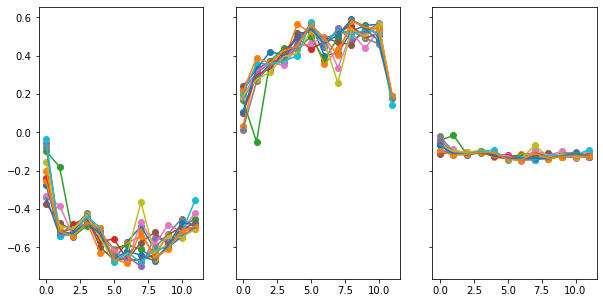

In [22]:
stack_plot_corr(
    {j:[torch.abs(i) for i in k] for j,k in hidden_states_special.items()}, attention_special, masks_special, 
    outliers_idxs=outliers_idxs, random_dims=set(hidden_states_special.keys()).difference([308, 381])
)

(<Figure size 720x360 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

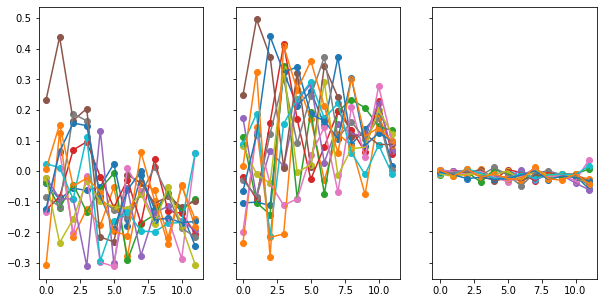

In [23]:
stack_plot_corr(
    {j:[torch.abs(i) for i in k] for j,k in hidden_states_no_special.items()}, attention_no_special, masks_no_special, 
    outliers_idxs=outliers_idxs, random_dims=set(hidden_states_no_special.keys()).difference([308, 381])
)

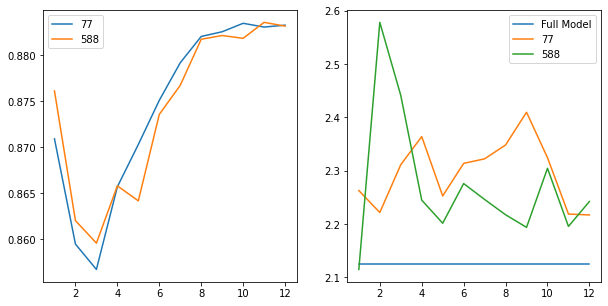

In [24]:
if model_name == "bert-base-uncased":
    col_order = ["308", "381", "308, 381", "Full Model"]
elif model_name == "roberta-base":
    col_order = ["77", "588", "77, 588", "Full Model"]

with open("output/baselines/scores/roberta-base/layer_size_1_results.json") as nli_file:
    nli_scores = json.load(nli_file)
with open("output/mlm_loss/roberta-base/results_by_layer.json") as mlm_file:
    mlm_loss = json.load(mlm_file)

df_score = pd.DataFrame.from_dict(nli_scores).applymap(lambda x: x["eval_accuracy"]).T
df_score.reset_index(drop=True, inplace=True)
df_score.index = df_score.index + 1

df_loss = pd.DataFrame.from_dict(mlm_loss).T
df_loss.reset_index(drop=True, inplace=True)
df_loss.rename({"":"Full Model"}, axis=1, inplace=True)
df_loss.drop("_".join(str(i) for i in outliers_idxs), axis=1, inplace=True)
df_loss.index = df_loss.index + 1

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
df_score.plot(ax=ax[0])
df_loss.plot(ax=ax[1]);

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Reusing dataset glue (/home/nlp/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 5/5 [00:00<00:00, 762.10it/s]


Thebes held onto power until the 12th Dynasty, when its first king, Amenemhet Iwho reigned between 1980 1951 b.c. established a capital near Memphis.
The capital near Memphis lasted only half a century before its inhabitants abandoned it for the next capital. 
Ignored unknown kwarg option direction


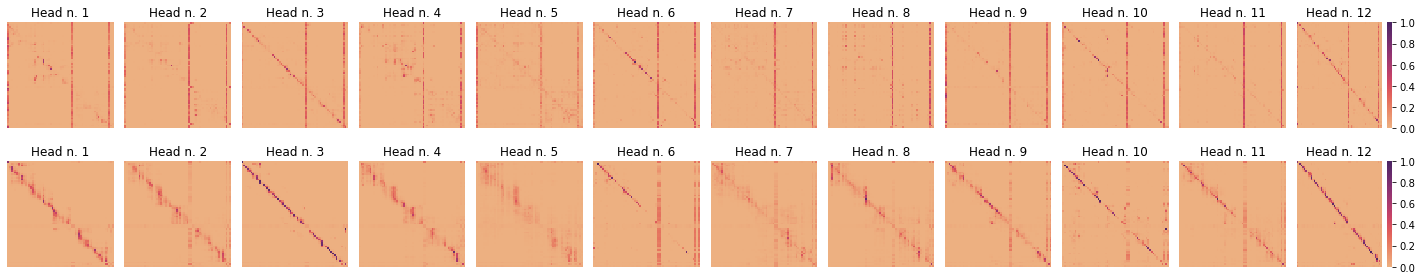

In [ ]:
fig_nrows = 2
fig_ncols = 12

model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
newmodel = deepcopy(model)
newmodel = zero_param_(newmodel, outliers_idxs)


ds = load_dataset("glue", "mnli")

sent_idx = 13
sentence1 = ds["train"]["premise"][sent_idx]
sentence2 = ds["train"]["hypothesis"][sent_idx]

print(sentence1)
print(sentence2)

tokenized = tokenizer(sentence1, sentence2, return_tensors="pt", truncation=True,)

att_plot_idx = 10

palette = sns.color_palette("flare", as_cmap=True)

att_fig1, ax = plt.subplots(fig_nrows, fig_ncols, figsize=(20, 4))
atts = [
    model(**tokenized, output_attentions=True).attentions[att_plot_idx],
    newmodel(**tokenized, output_attentions=True).attentions[att_plot_idx]
]
for j in range(2):
    for i in range(12):
        sns.heatmap(atts[j][0, i, :].detach(), ax=ax[j, i], vmin=0, vmax=1, cmap=palette, cbar=i==11)
        ax[j, i].axis('off')
        ax[j, i].set_title(f"Head n. {i + 1}")


plt.tight_layout()